# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Statistical Libraries
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox

# Machine learning libraries
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("retail_sales_mock_data.csv")

In [3]:
df.head()

,Date,SalesAmount,Promotion,HolidayMonth
0,2020-01-01,12248,0,0
1,2020-02-01,13011,0,0
2,2020-03-01,12722,0,0
3,2020-04-01,14030,1,0
4,2020-05-01,7783,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          48 non-null     object
 1   SalesAmount   48 non-null     int64 
 2   Promotion     48 non-null     int64 
 3   HolidayMonth  48 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 1.6+ KB


In [5]:
# Converting "Date" to date_time
df["Date"] = pd.to_datetime(df["Date"])

# Converting "Date" to index
df.set_index("Date", inplace=True)
df.head(5)

,SalesAmount,Promotion,HolidayMonth
Date,,,
2020-01-01,12248,0,0
2020-02-01,13011,0,0
2020-03-01,12722,0,0
2020-04-01,14030,1,0
2020-05-01,7783,0,0


In [6]:
df.columns

Index(['SalesAmount', 'Promotion', 'HolidayMonth'], dtype='object')

In [7]:
df.isnull().sum()

,0
SalesAmount,0
Promotion,0
HolidayMonth,0


In [8]:
df.duplicated().sum()

np.int64(0)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2020-01-01 to 2023-12-01
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   SalesAmount   48 non-null     int64
 1   Promotion     48 non-null     int64
 2   HolidayMonth  48 non-null     int64
dtypes: int64(3)
memory usage: 1.5 KB


# Exploratory Data Analysis (EDA)

## Univariate Analysis

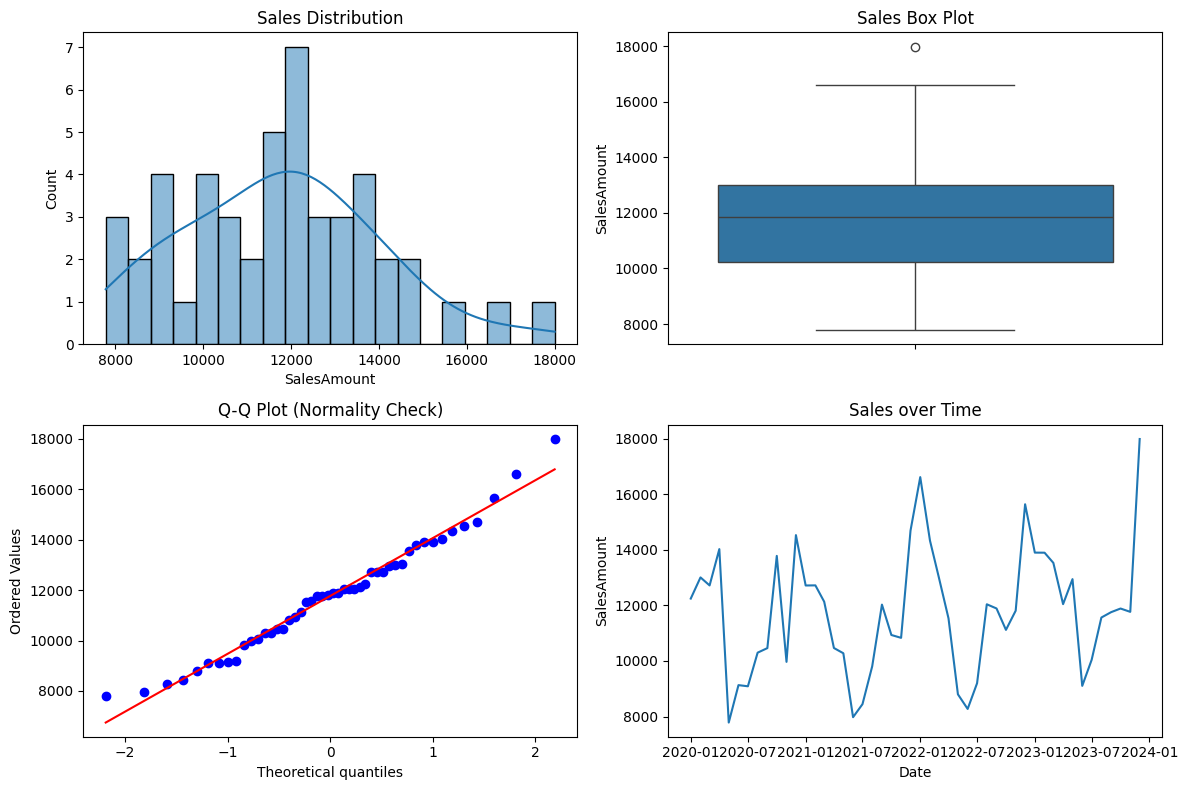

In [10]:
fig, ax= plt.subplots(2,2, figsize=(12,8))

# Hist Plot
sns.histplot(df["SalesAmount"], bins=20, kde=True, ax=ax[0,0])
ax[0,0].set_title("Sales Distribution")

# Box Plot
sns.boxplot(df["SalesAmount"], ax=ax[0,1])
ax[0,1].set_title("Sales Box Plot")

# Q_Q Plot
stats.probplot(df["SalesAmount"], dist="norm", plot=ax[1,0])
ax[1,0].set_title("Q-Q Plot (Normality Check)")

# Line Plot
sns.lineplot(x=df.index, y=df["SalesAmount"], ax=ax[1,1])
ax[1,1].set_title("Sales over Time")

plt.tight_layout()
plt.show()

## Time Series Visulaization

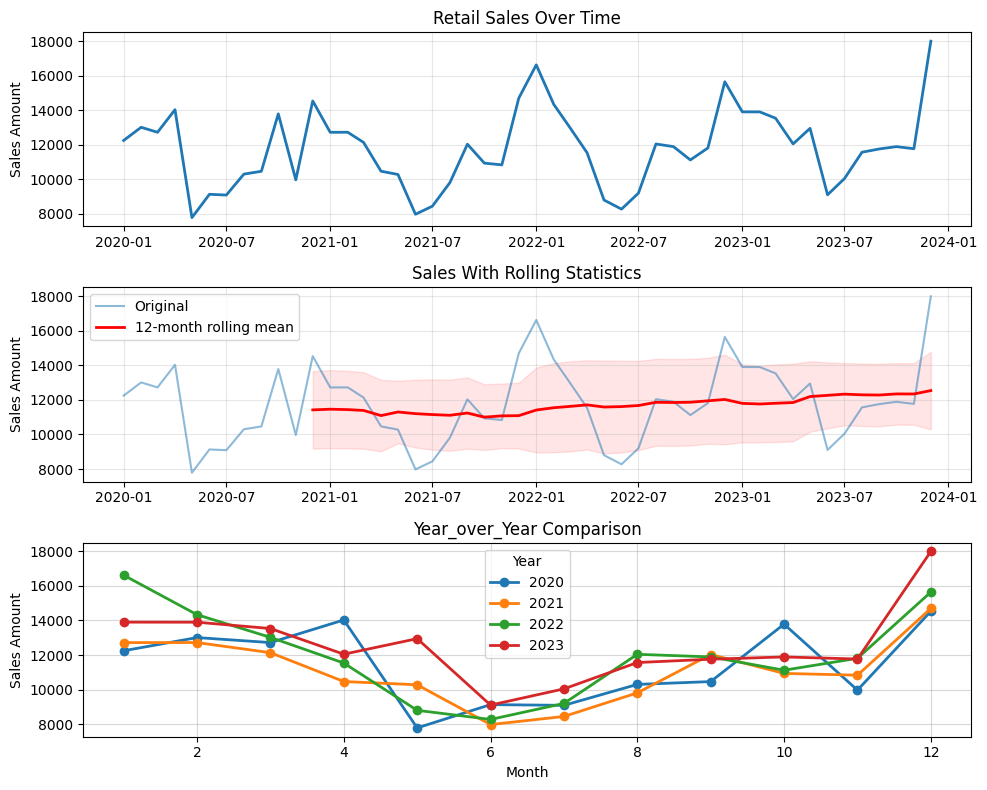

In [11]:
fig, axes = plt.subplots(3,1, figsize=(10,8))

# Plotting main time series analysis
axes[0].plot(df.index, df["SalesAmount"], linewidth=2)
axes[0].set(title="Retail Sales Over Time", ylabel="Sales Amount")
axes[0].grid(True, alpha=0.3)

# Adding rolling statistics
rolling_mean = df["SalesAmount"].rolling(window=12).mean()
rolling_std = df["SalesAmount"].rolling(window=12).std()

axes[1].plot(df.index, df["SalesAmount"], label='Original', alpha=0.5)
axes[1].plot(df.index, rolling_mean, label="12-month rolling mean", color="red", linewidth=2)
axes[1].fill_between(df.index, rolling_mean - rolling_std, rolling_mean + rolling_std, color="red", alpha=0.1)
axes[1].set(title="Sales With Rolling Statistics", ylabel="Sales Amount")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Year over Year comparison
df["Year"] = df.index.year
df["Month"] = df.index.month

yearly_data = df.groupby(['Year','Month'])["SalesAmount"].mean().unstack(level=0)
yearly_data.plot(ax=axes[2], marker='o', linewidth=2)
axes[2].set(title="Year_over_Year Comparison", ylabel="Sales Amount")
axes[2].legend(title='Year')
axes[2].grid(True, alpha=0.5)

plt.tight_layout()
plt.show()

## Seasonal Decomposition

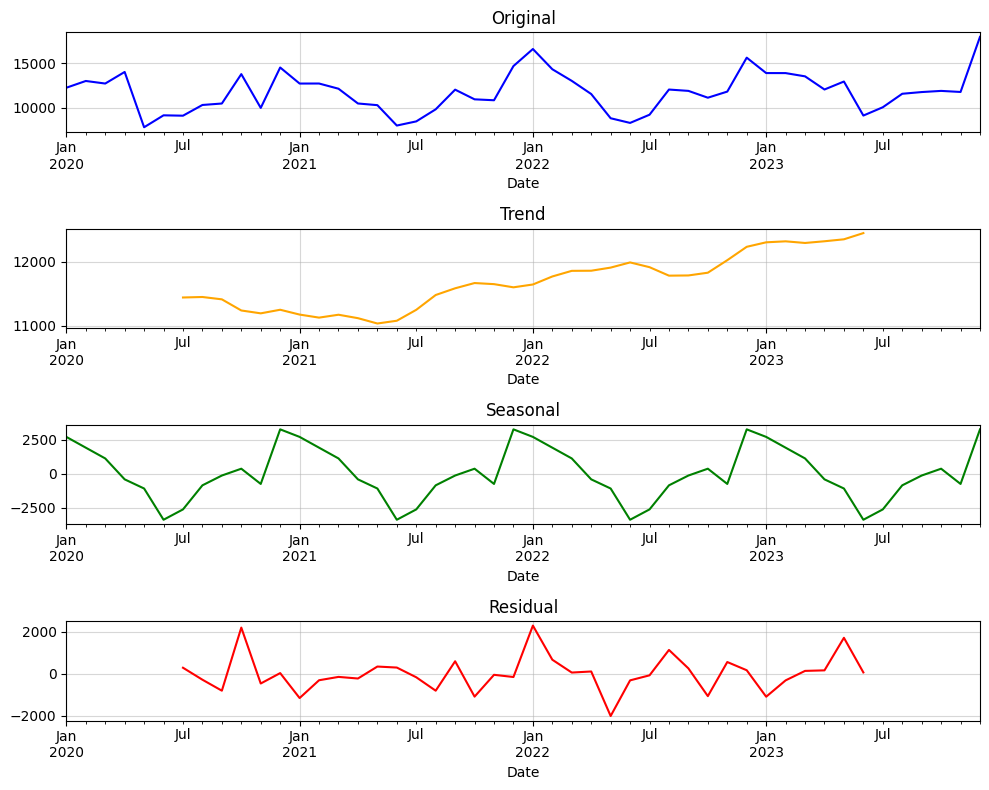

Average Seasonal Patterns by month
January: 2697.58
February: 1904.76
March: 1113.19
April: -425.13
May: -1098.81
June: -3396.91
July: -2635.88
August: -864.57
September: -143.54
October: 358.37
November: -762.18
December: 3253.11


In [12]:
decomposition = seasonal_decompose(df["SalesAmount"], model="additive", period=12)

fig, axes = plt.subplots(4,1, figsize=(10,8))

# Original Series
decomposition.observed.plot(ax=axes[0], title="Original", color="blue")
decomposition.trend.plot(ax=axes[1], title="Trend", color="orange")
decomposition.seasonal.plot(ax=axes[2],title="Seasonal", color='green')
decomposition.resid.plot(ax=axes[3], title="Residual", color="red")

for ax in axes:
  ax.grid(True, alpha=0.5)

plt.tight_layout()
plt.show()

# Analyzing Seasonal Component
seasonal_pattern = decomposition.seasonal.groupby(decomposition.seasonal.index.month).mean()
print("Average Seasonal Patterns by month")
for month,value in seasonal_pattern.items():
  month_name = pd.to_datetime(f'2020-{month:02d}-01').strftime('%B')
  print(f"{month_name}: {value:.2f}")

## Feature Analysis

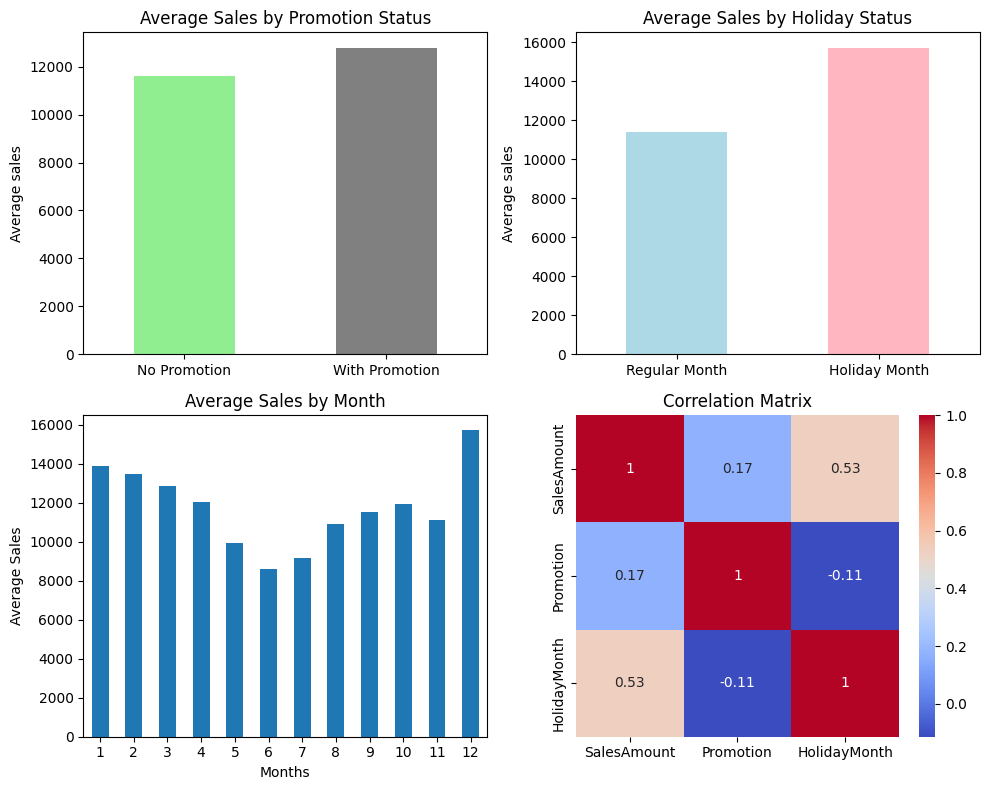

In [13]:
fig, axes = plt.subplots(2,2, figsize=(10,8))

# Promotion Analysis
promo_analysis = df.groupby('Promotion')["SalesAmount"].agg(['mean', 'std','count'])
promo_analysis.index = ["No Promotion", "With Promotion"]
promo_analysis['mean'].plot(kind='bar', ax=axes[0,0], color=['lightgreen', 'grey'])
axes[0,0].set(ylabel="Average sales", title="Average Sales by Promotion Status")
axes[0,0].tick_params(axis='x', rotation=0)

# Holiday Impact
holiday_analysis = df.groupby("HolidayMonth")["SalesAmount"].agg(["mean", "std", "count"])
holiday_analysis.index = ["Regular Month", "Holiday Month"]
holiday_analysis['mean'].plot(kind='bar', ax=axes[0,1], color=['lightblue', 'lightpink'])
axes[0,1].set(ylabel="Average sales", title="Average Sales by Holiday Status")
axes[0,1].tick_params(axis='x', rotation=0)

#Plotting monthly pattern
monthly_avg = df.groupby(df.index.month)["SalesAmount"].mean()
monthly_avg.plot(kind='bar', ax=axes[1,0])
axes[1,0].set(title="Average Sales by Month", xlabel="Months", ylabel="Average Sales")
axes[1,0].tick_params(axis='x', rotation=0)

# Corelation Heatmap
corr_matrix = df[["SalesAmount", "Promotion", "HolidayMonth"]].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=axes[1,1])
axes[1,1].set(title="Correlation Matrix")

plt.tight_layout()
plt.show()


## Business Insights

In [14]:
promo_lift = ((promo_analysis.loc["With Promotion", "mean"] - promo_analysis.loc["No Promotion", "mean"]) /promo_analysis.loc["No Promotion", "mean"]) * 100
Holiday_lift = ((holiday_analysis.loc["Holiday Month", "mean"]-holiday_analysis.loc["Regular Month", "mean"])/holiday_analysis.loc["Regular Month", "mean"]) * 100

print(f"Promotion Lift: {promo_lift:.2f}%")
print(f"Holiday Lift: {Holiday_lift:.2f}%")
print(f"Peak Sales Month: {monthly_avg.idxmax()} (Month {monthly_avg.idxmax()})")
print(f"Least Sales Month: {monthly_avg.idxmin()} (Month {monthly_avg.idxmin()})")

Promotion Lift: 10.14%
Holiday Lift: 37.76%
Peak Sales Month: 12 (Month 12)
Least Sales Month: 6 (Month 6)


# Statistical Analysis

## Checking for stationary data

In [15]:
def stationary_check(timeseries, title):

  print(f"Stationary Test for {title}")
  print("-" * 40)

# Performing Augmented Dickey Fuller Test(adf test)

  adf_test = adfuller(timeseries)
  print("Results of Augmented Dickey-Fuller Test:")
  print(f"ADF Statistic: {adf_test[0]:.6f}")
  print(f"p_value: {adf_test[1]:.6f}")
  print("Critical Values:")
  for key, value in adf_test[4].items():
    print(f"\t {key} : {value:.3f}")

  if adf_test[1] < 0.05:
    print("Data is stationary")
  else:
    print("Data is not stationary")

# Performing KPSS test
  kpss_test = kpss(timeseries)
  print("\nResults of KPSS Test:")
  print(f"KPSS Statistic: {kpss_test[0]:.6f}")
  print(f"p_value: {kpss_test[1]:.6f}")
  print("Critical Values:")
  for key, value in kpss_test[3].items():
    print(f"\t {key} : {value:.3f}")

  if kpss_test[1] < 0.05:
    print("Data is Not stationary")
  else:
    print("Data is Stationary")


stationary_check(df["SalesAmount"],"Original Sales data" )

Stationary Test for Original Sales data
----------------------------------------
Results of Augmented Dickey-Fuller Test:
ADF Statistic: -4.514184
p_value: 0.000185
Critical Values:
	 1% : -3.597
	 5% : -2.933
	 10% : -2.605
Data is stationary

Results of KPSS Test:
KPSS Statistic: 0.138846
p_value: 0.100000
Critical Values:
	 10% : 0.347
	 5% : 0.463
	 2.5% : 0.574
	 1% : 0.739
Data is Stationary


<ipython-input-15-d113cb4124b2>:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(timeseries)


## Auto_corelation Analysis

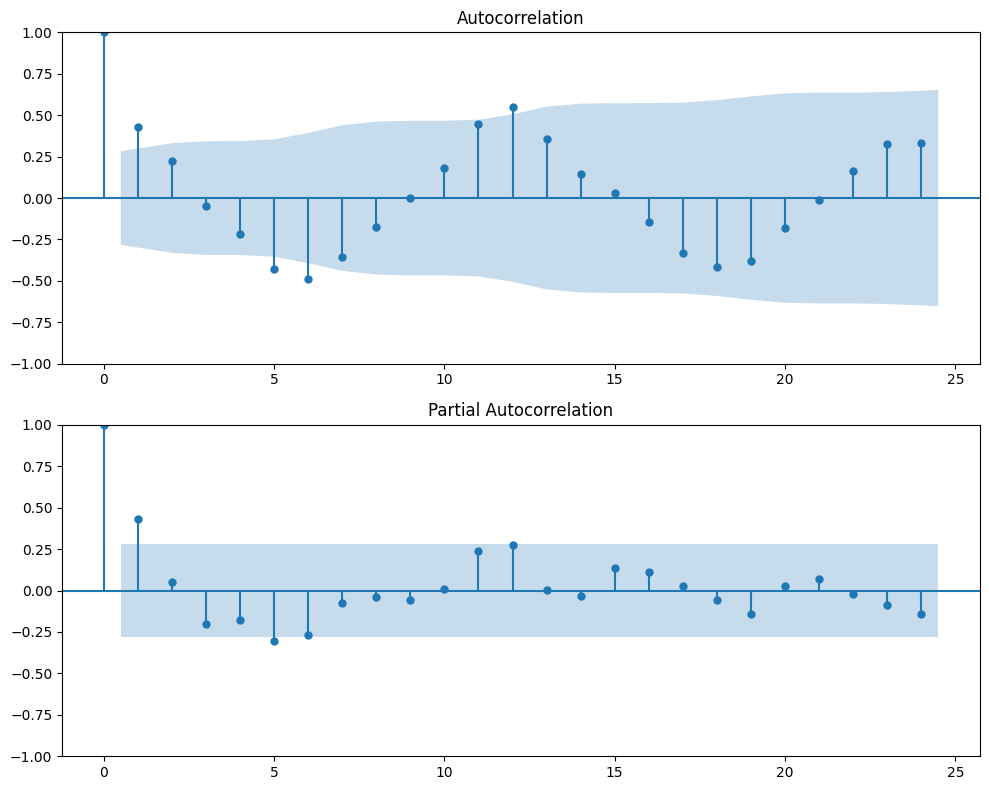

In [16]:
# Plotting ACF and PACF plots
fig, axes = plt.subplots(2,1, figsize=(10,8))

plot_acf(df["SalesAmount"], lags=24, ax=axes[0])
plot_pacf(df["SalesAmount"],lags=24, ax=axes[1])

plt.tight_layout()
plt.show()

# Feature Engineering

In [17]:
# Creating lag features
lag_periods= [1,3,6,12]
for lag in lag_periods:
  df[f"Sales_lag_{lag}"] = df["SalesAmount"].shift(lag)


# Creating Time based features
df["month"] = df.index.month
df["quarter"] = df.index.quarter
df["year"] = df.index.year
df["days"] = df.index.day_name

# Cycling encoding for seasonality
df["sin_month"] = np.sin(2 * np.pi * df['month'] / 12)
df["cos_month"] = np.cos(2 * np.pi * df['month'] / 12)

# Creating rolling window features
windows = [3, 6, 12]
for window in windows:
    df[f'rolling_mean_{window}'] = df['SalesAmount'].rolling(window=window).mean()
    df[f'rolling_std_{window}'] = df['SalesAmount'].rolling(window=window).std()

# Creating growth and change features
df['pct_change_1'] = df['SalesAmount'].pct_change(1)
df['pct_change_12'] = df['SalesAmount'].pct_change(12)

# Model Selection and Training

In [18]:
clean_df = df.dropna()

# Splitting data into train and test
split_data = clean_df.index[int(0.8 * len(clean_df))]
train_data = clean_df[clean_df.index <= split_data]
test_data = clean_df[clean_df.index > split_data]

# Defining evaluation function
def evaluate_forecast(actual, predicted, model_name):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100

    return {
        'Model': model_name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape
    }

results = []

# Seasonal naive (same month last year)
seasonal_naive_forecast = []
for i in range(len(test_data)):
    try:
        same_month_last_year = train_data[train_data.index.month == test_data.index[i].month]['SalesAmount'].iloc[-1]
        seasonal_naive_forecast.append(same_month_last_year)
    except:
        seasonal_naive_forecast.append(train_data['SalesAmount'].mean())

results.append(evaluate_forecast(test_data['SalesAmount'], seasonal_naive_forecast, 'Seasonal Naive'))

try:
    # Simple ARIMA
    arima_model = ARIMA(train_data['SalesAmount'], order=(1, 1, 1))
    arima_fit = arima_model.fit()
    arima_forecast = arima_fit.forecast(steps=len(test_data))
    results.append(evaluate_forecast(test_data['SalesAmount'], arima_forecast, 'ARIMA(1,1,1)'))
    print("ARIMA(1,1,1) model trained successfully")

    # SARIMA
    sarima_model = SARIMAX(train_data['SalesAmount'],
                          order=(1, 1, 1),
                          seasonal_order=(1, 1, 1, 12))
    sarima_fit = sarima_model.fit(disp=False)
    sarima_forecast = sarima_fit.forecast(steps=len(test_data))
    results.append(evaluate_forecast(test_data['SalesAmount'], sarima_forecast, 'SARIMA(1,1,1)(1,1,1,12)'))
    print("SARIMA model trained successfully")

except Exception as e:
    print(f"Error training ARIMA models: {e}")

try:
    # Simple Exponential Smoothing
    ses_model = ExponentialSmoothing(train_data['SalesAmount'], trend=None, seasonal=None)
    ses_fit = ses_model.fit()
    ses_forecast = ses_fit.forecast(steps=len(test_data))
    results.append(evaluate_forecast(test_data['SalesAmount'], ses_forecast, 'Simple Exp Smoothing'))

    # Holt-Winters
    hw_model = ExponentialSmoothing(train_data['SalesAmount'],
                                   trend='add',
                                   seasonal='add',
                                   seasonal_periods=12)
    hw_fit = hw_model.fit()
    hw_forecast = hw_fit.forecast(steps=len(test_data))
    results.append(evaluate_forecast(test_data['SalesAmount'], hw_forecast, 'Holt-Winters'))
    print("Exponential smoothing models trained successfully")

except Exception as e:
    print(f"Error training exponential smoothing models: {e}")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

ARIMA(1,1,1) model trained successfully
SARIMA model trained successfully
Exponential smoothing models trained successfully


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


# Evaluating Model

                  Model     MAE         MSE    RMSE  MAPE
           Holt-Winters  583.61   764943.64  874.61  4.25
         Seasonal Naive  778.00  1109536.29 1053.35  6.10
   Simple Exp Smoothing 2372.86  7792456.26 2791.50 20.03
           ARIMA(1,1,1) 2447.96  8014714.62 2831.03 20.78
SARIMA(1,1,1)(1,1,1,12) 4401.88 20285654.46 4503.96 38.74

Best performing model: Holt-Winters


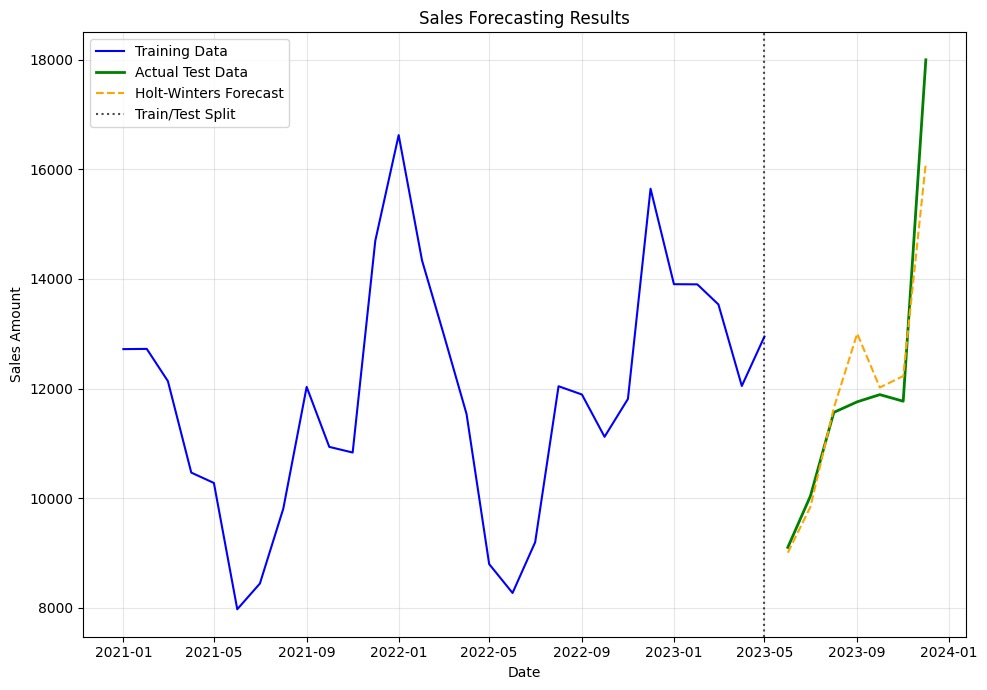

In [19]:
# Evaluating model and selecting best model

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('RMSE')

print(results_df.to_string(index=False, float_format='%.2f'))

best_model_name = results_df.iloc[0]['Model']
print(f"\nBest performing model: {best_model_name}")

# Visualizing forecasts

fig, ax = plt.subplots(figsize=(10, 7))

# Plotting actual data
ax.plot(train_data.index, train_data['SalesAmount'], label='Training Data', color='blue')
ax.plot(test_data.index, test_data['SalesAmount'], label='Actual Test Data', color='green', linewidth=2)

ax.plot(test_data.index, hw_forecast, label='Holt-Winters Forecast', color='orange', linestyle='--')

ax.axvline(x=split_data, color='black', linestyle=':', alpha=0.7, label='Train/Test Split')
ax.set_title('Sales Forecasting Results')
ax.set_xlabel('Date')
ax.set_ylabel('Sales Amount')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Forecasting the next 6 months sales

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


6-Month Sales Forecast:
            Forecast  Lower_CI  Upper_CI
Date                                    
2024-01-01   16049.0   14405.0   17694.0
2024-02-01   14889.0   13245.0   16533.0
2024-03-01   14065.0   12420.0   15709.0
2024-04-01   12608.0   10963.0   14252.0
2024-05-01   11701.0   10056.0   13345.0
2024-06-01    9472.0    7827.0   11116.0


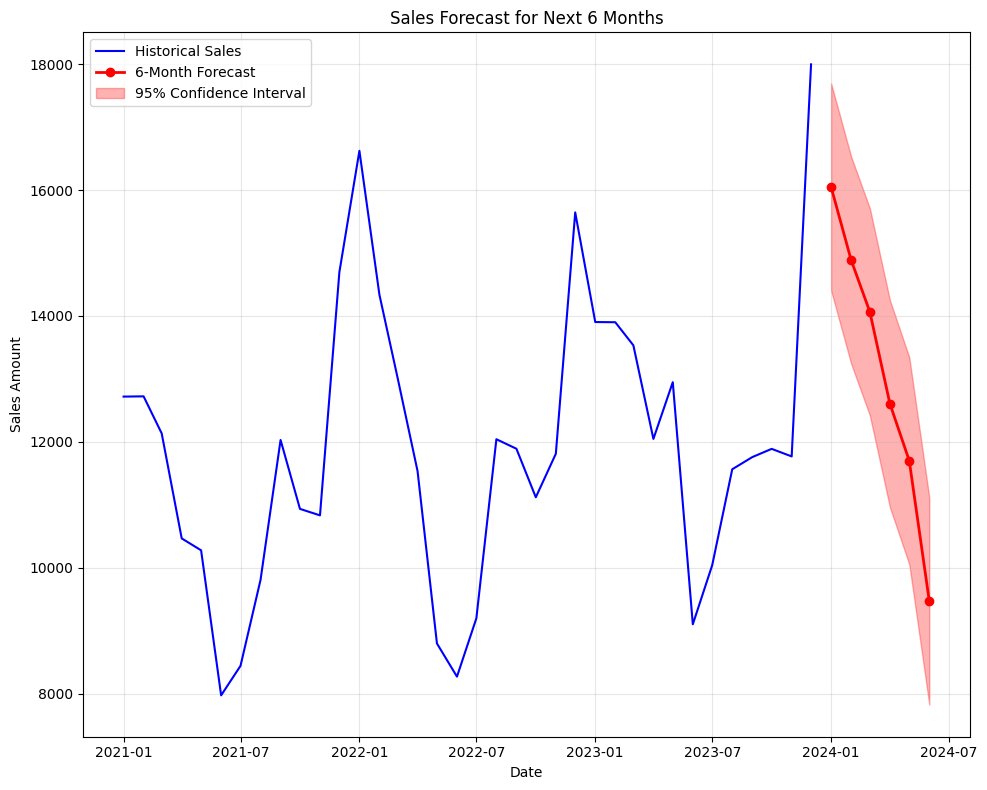

In [22]:
final_model = ExponentialSmoothing(clean_df['SalesAmount'],
                                         trend='add',
                                         seasonal='add',
                                         seasonal_periods=12)
final_fit = final_model.fit()

# Generating 6-month forecast
forecast_steps = 6
forecast = final_fit.forecast(steps=forecast_steps)

# Simple confidence intervals for Holt-Winters
forecast_std = np.std(final_fit.resid)
forecast_ci = pd.DataFrame({
  'lower SalesAmount': forecast - 1.96 * forecast_std,
   'upper SalesAmount': forecast + 1.96 * forecast_std
        })

# Creating forecast dates
last_date = clean_df.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1),
                                  periods=forecast_steps,
                                  freq='MS')

# Creating forecast dataframe
forecast_df = pd.DataFrame({
        'Date': forecast_dates,
        'Forecast': forecast.values,
        'Lower_CI': forecast_ci.iloc[:, 0].values,
        'Upper_CI': forecast_ci.iloc[:, 1].values
    })
forecast_df.set_index('Date', inplace=True)

print("6-Month Sales Forecast:")
print(forecast_df.round(0))

# Plotting final forecast
fig, ax = plt.subplots(figsize=(10, 8))

# Plotting historical data
ax.plot(clean_df.index, clean_df['SalesAmount'], label='Historical Sales', color='blue')

# Plotting forecast
ax.plot(forecast_df.index, forecast_df['Forecast'], label='6-Month Forecast', color='red', linewidth=2, marker='o')

# Plotting confidence intervals
ax.fill_between(forecast_df.index,
                   forecast_df['Lower_CI'],
                   forecast_df['Upper_CI'],
                   alpha=0.3, color='red', label='95% Confidence Interval')

ax.set_title('Sales Forecast for Next 6 Months')
ax.set_xlabel('Date')
ax.set_ylabel('Sales Amount')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [21]:
# Converting the forecast DataFrame to a CSV file
forecast_df.to_csv("sales_forecast.csv", index=True)

print("6-month sales forecast saved to sales_forecast.csv")

6-month sales forecast saved to sales_forecast.csv
